In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
from tensorflow.keras.applications import VGG19, InceptionV3, DenseNet121
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Reshape, Bidirectional, LSTM, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from deap import base, creator, tools, algorithms


In [2]:
data_dir = "C:/Users/sadhi/Downloads/archive (3)/Brain_Data_Organised"
categories = ["Normal", "Stroke"]
labels = {"Normal": 0, "Stroke": 1}

In [3]:
def show_sample_images():
    plt.figure(figsize=(12, 6))

    normal_path = os.path.join(data_dir, "Normal")
    stroke_path = os.path.join(data_dir, "Stroke")
    
    normal_img_name = random.choice(os.listdir(normal_path))
    stroke_img_name = random.choice(os.listdir(stroke_path))
    
    normal_img_path = os.path.join(normal_path, normal_img_name)
    stroke_img_path = os.path.join(stroke_path, stroke_img_name)
    
    normal_img_orig = cv2.imread(normal_img_path)
    normal_img_orig = cv2.cvtColor(normal_img_orig, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    stroke_img_orig = cv2.imread(stroke_img_path)
    stroke_img_orig = cv2.cvtColor(stroke_img_orig, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    plt.subplot(2, 2, 1)
    plt.imshow(normal_img_orig)
    plt.title(f"Original Normal Image\nShape: {normal_img_orig.shape}")
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(stroke_img_orig)
    plt.title(f"Original Stroke Image\nShape: {stroke_img_orig.shape}")
    plt.axis('off')
    
    IMG_SIZE = (224, 224)
    normal_img_resized = cv2.resize(normal_img_orig, IMG_SIZE)
    stroke_img_resized = cv2.resize(stroke_img_orig, IMG_SIZE)
    
    plt.subplot(2, 2, 3)
    plt.imshow(normal_img_resized)
    plt.title(f"Resized Normal Image\nShape: {normal_img_resized.shape}")
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(stroke_img_resized)
    plt.title(f"Resized Stroke Image\nShape: {stroke_img_resized.shape}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('preprocessing_visualization.png')
    plt.show()
    
    return normal_img_orig, stroke_img_orig, normal_img_resized, stroke_img_resized


Visualizing preprocessing steps...


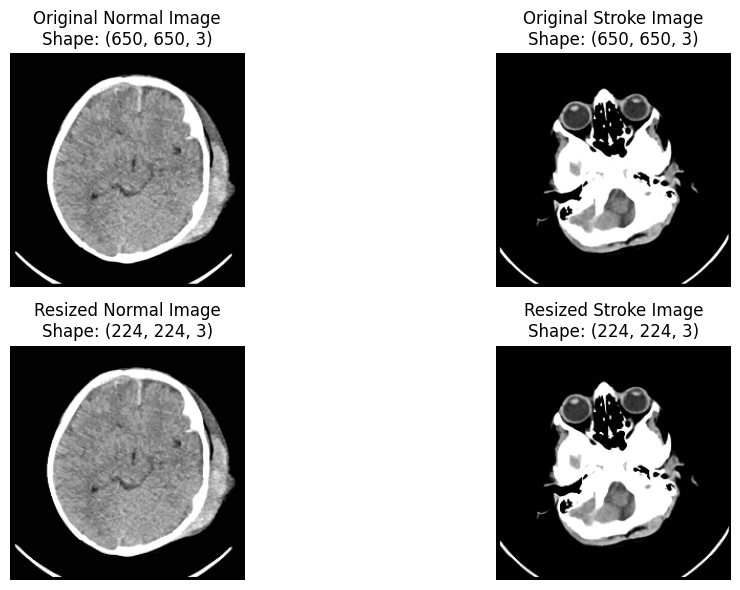

In [4]:

print("Visualizing preprocessing steps...")
normal_img_orig, stroke_img_orig, normal_img_resized, stroke_img_resized = show_sample_images()

images, image_labels = [], []
IMG_SIZE = (224, 224) 

for category in categories:
    path = os.path.join(data_dir, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                image_labels.append(labels[category])
            else:
                print(f"Skipping unreadable image: {img_path}")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

images = np.array(images, dtype=np.float32) / 255.0  
image_labels = np.array(image_labels)


In [5]:
# Handle Dataset Imbalance (Oversampling Stroke Images)
stroke_images = images[image_labels == 1]
normal_images = images[image_labels == 0]

print(f"Original dataset: {len(normal_images)} normal images, {len(stroke_images)} stroke images")

# Corrected: Oversampling the minority class (stroke) instead of undersampling the majority class
if len(stroke_images) < len(normal_images):
    stroke_images_resampled = resample(stroke_images, replace=True, 
                                     n_samples=len(normal_images), 
                                     random_state=42)
    images_balanced = np.vstack((stroke_images_resampled, normal_images))
    labels_balanced = np.array([1] * len(stroke_images_resampled) + [0] * len(normal_images))
else:
    normal_images_resampled = resample(normal_images, replace=True, 
                                      n_samples=len(stroke_images), 
                                      random_state=42)
    images_balanced = np.vstack((stroke_images, normal_images_resampled))
    labels_balanced = np.array([1] * len(stroke_images) + [0] * len(normal_images_resampled))

print(f"Balanced dataset: {len(images_balanced)} images with {np.sum(labels_balanced == 0)} normal and {np.sum(labels_balanced == 1)} stroke")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images_balanced, labels_balanced, test_size=0.2, random_state=42)


Original dataset: 1551 normal images, 949 stroke images
Balanced dataset: 3102 images with 1551 normal and 1551 stroke


In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2481, 224, 224, 3)
(621, 224, 224, 3)
(2481,)
(621,)


In [7]:
def create_alexnet(input_shape=(224, 224, 3)):
    model = Sequential([
        
        tf.keras.layers.Conv2D(96, 11, strides=4, padding='same', input_shape=input_shape, activation='relu'),
        tf.keras.layers.MaxPooling2D(3, strides=2),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(256, 5, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(3, strides=2),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(3, strides=2),
        
        tf.keras.layers.GlobalAveragePooling2D()
    ])
    return model


In [8]:

def create_shufflenet(input_shape=(224, 224, 3), groups=3):
    def shuffle_unit(x, filters, groups, strides=1):
        shortcut = x
        
        x = tf.keras.layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        if groups > 1:
            channels_per_group = filters // groups
            x = tf.keras.layers.Lambda(
                lambda z: tf.reshape(
                    z, [-1, tf.shape(z)[1], tf.shape(z)[2], groups, channels_per_group]
                )
            )(x)
            
            x = tf.keras.layers.Lambda(
                lambda z: tf.transpose(z, [0, 1, 2, 4, 3])
            )(x)
            
            x = tf.keras.layers.Lambda(
                lambda z: tf.reshape(
                    z, [-1, tf.shape(z)[1], tf.shape(z)[2], filters]
                )
            )(x)
        
        x = tf.keras.layers.DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        if strides == 1:
            x = tf.keras.layers.add([x, shortcut])
        
        return tf.keras.layers.Activation('relu')(x)
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    x = tf.keras.layers.Conv2D(24, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    x = shuffle_unit(x, 240, groups, strides=2)
    x = shuffle_unit(x, 240, groups)
    x = shuffle_unit(x, 240, groups)
    x = shuffle_unit(x, 240, groups)
    
    x = shuffle_unit(x, 480, groups, strides=2)
    x = shuffle_unit(x, 480, groups)
    x = shuffle_unit(x, 480, groups)
    x = shuffle_unit(x, 480, groups)
    
    x = shuffle_unit(x, 960, groups, strides=2)
    x = shuffle_unit(x, 960, groups)
    x = shuffle_unit(x, 960, groups)
    x = shuffle_unit(x, 960, groups)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

In [9]:
def alexnet_preprocess(x):
    return (x - 127.5) / 127.5

def shufflenet_preprocess(x):
    return x / 255.0

def show_preprocessing_comparison():
    plt.figure(figsize=(15, 10))
    
    sample_img = X_train[0] * 255.0 
    
    plt.subplot(2, 3, 1)
    plt.imshow(sample_img / 255.0) 
    plt.title("Original Image")
    plt.axis("off")
    
    # VGG19 preprocessing
    vgg_processed = vgg_preprocess(np.copy(sample_img))
    plt.subplot(2, 3, 2)
    plt.imshow((vgg_processed - vgg_processed.min()) / (vgg_processed.max() - vgg_processed.min()))
    plt.title("VGG19 Preprocessing")
    plt.axis("off")
    
    # Inception preprocessing
    inception_processed = inception_preprocess(np.copy(sample_img))
    plt.subplot(2, 3, 3)
    plt.imshow((inception_processed - inception_processed.min()) / (inception_processed.max() - inception_processed.min()))
    plt.title("InceptionV3 Preprocessing")
    plt.axis("off")
    # DenseNet preprocessing
    densenet_processed = densenet_preprocess(np.copy(sample_img))
    plt.subplot(2, 3, 4)
    plt.imshow((densenet_processed - densenet_processed.min()) / (densenet_processed.max() - densenet_processed.min()))
    plt.title("DenseNet121 Preprocessing")
    plt.axis("off")
    
    # AlexNet preprocessing
    alexnet_processed = alexnet_preprocess(np.copy(sample_img / 255.0))
    plt.subplot(2, 3, 5)
    plt.imshow((alexnet_processed - alexnet_processed.min()) / (alexnet_processed.max() - alexnet_processed.min()))
    plt.title("AlexNet Preprocessing")
    plt.axis("off")
    
    # ShuffleNet preprocessing
    shufflenet_processed = shufflenet_preprocess(np.copy(sample_img))
    plt.subplot(2, 3, 6)
    plt.imshow(shufflenet_processed)
    plt.title("ShuffleNet Preprocessing")
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig('model_preprocessing_comparison.png')
    plt.show()


Visualizing preprocessing effects for different models...


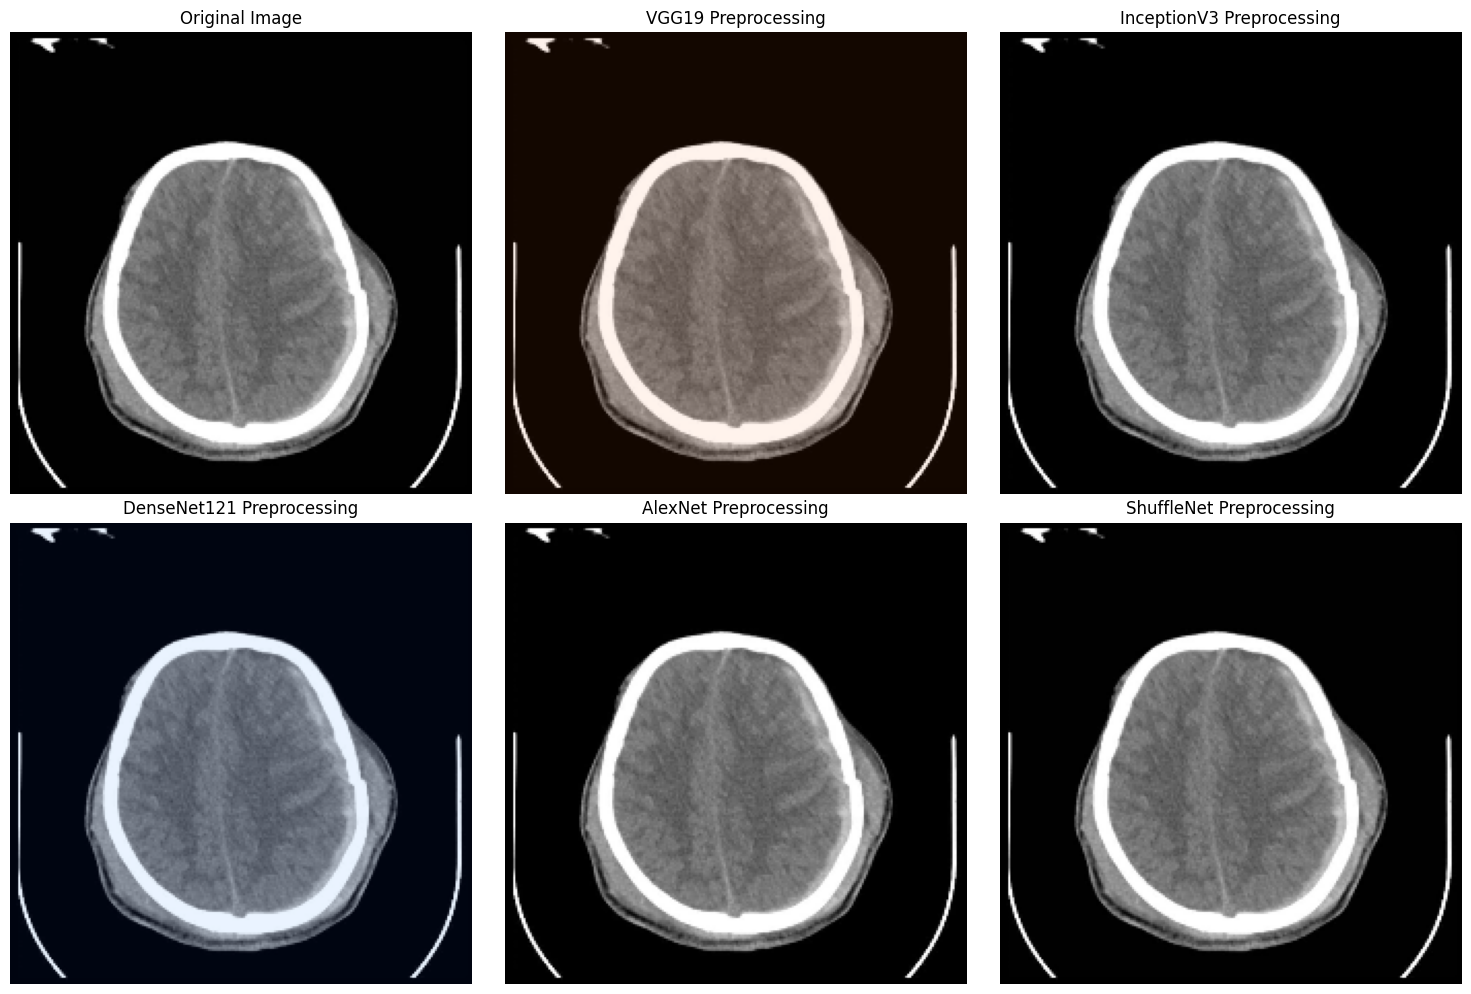

C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Extracting features using VGG19...
156/156 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step
VGG19 feature shape: (2481, 512), Extraction time: 367.06 seconds
Extracting features using InceptionV3...


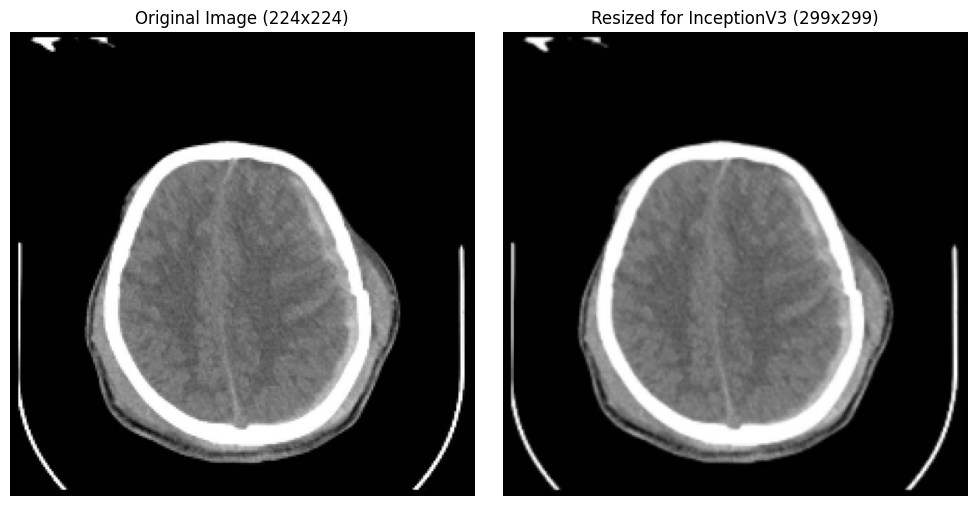

156/156 ━━━━━━━━━━━━━━━━━━━━ 118s 717ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 771ms/step
InceptionV3 feature shape: (2481, 2048), Extraction time: 160.53 seconds
Extracting features using DenseNet121...
156/156 ━━━━━━━━━━━━━━━━━━━━ 121s 728ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 707ms/step
DenseNet121 feature shape: (2481, 1024), Extraction time: 157.49 seconds
Extracting features using AlexNet...
156/156 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step
AlexNet feature shape: (2481, 256), Extraction time: 24.28 seconds
Extracting features using ShuffleNet...
156/156 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step
ShuffleNet feature shape: (2481, 960), Extraction time: 53.34 seconds
VGG19 extracted 512 features.
InceptionV3 extracted 2048 features.
DenseNet121 extracted 1024 features.
AlexNet extracted 256 features.
ShuffleNet extracted 960 features.


In [10]:
print("Visualizing preprocessing effects for different models...")
show_preprocessing_comparison()

base_models = {
    "VGG19": (VGG19(weights='imagenet', include_top=False), vgg_preprocess),
    "InceptionV3": (InceptionV3(weights='imagenet', include_top=False), inception_preprocess),
    "DenseNet121": (DenseNet121(weights='imagenet', include_top=False), densenet_preprocess),
    "AlexNet": (create_alexnet(), alexnet_preprocess),
    "ShuffleNet": (create_shufflenet(), shufflenet_preprocess)
}

extraction_times = {}
extracted_features_train = []
extracted_features_test = []

for model_name, (base_model, preprocess) in base_models.items():
    print(f"Extracting features using {model_name}...")
    start_time = time.time()
    
    if model_name == "InceptionV3":
        X_train_resized = np.array([cv2.resize(img, (299, 299)) for img in X_train])
        X_test_resized = np.array([cv2.resize(img, (299, 299)) for img in X_test])
        X_train_preprocessed = preprocess(X_train_resized * 255)
        X_test_preprocessed = preprocess(X_test_resized * 255)
        
        if model_name == "InceptionV3":
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(X_train[0])
            plt.title(f"Original Image (224x224)")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow((X_train_resized[0] - X_train_resized[0].min()) / (X_train_resized[0].max() - X_train_resized[0].min()))
            plt.title(f"Resized for InceptionV3 (299x299)")
            plt.axis('off')
            plt.tight_layout()
            plt.savefig('inception_resize_comparison.png')
            plt.show()
    else:
        if model_name in ["AlexNet", "ShuffleNet"]:
            X_train_preprocessed = preprocess(X_train)
            X_test_preprocessed = preprocess(X_test)
        else:
            X_train_preprocessed = preprocess(X_train * 255)
            X_test_preprocessed = preprocess(X_test * 255)
    
    if model_name not in ["AlexNet", "ShuffleNet"]:
        output_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
        model = Model(inputs=base_model.input, outputs=output_layer)
    else:
        model = base_model
    
    features_train = model.predict(X_train_preprocessed, batch_size=16, verbose=1)
    features_test = model.predict(X_test_preprocessed, batch_size=16, verbose=1)
    
    extraction_time = time.time() - start_time
    extraction_times[model_name] = extraction_time
    
    print(f"{model_name} feature shape: {features_train.shape}, Extraction time: {extraction_time:.2f} seconds")
    extracted_features_train.append(features_train)
    extracted_features_test.append(features_test)
for model_name, features in zip(base_models.keys(), extracted_features_train):
    print(f"{model_name} extracted {features.shape[1]} features.")

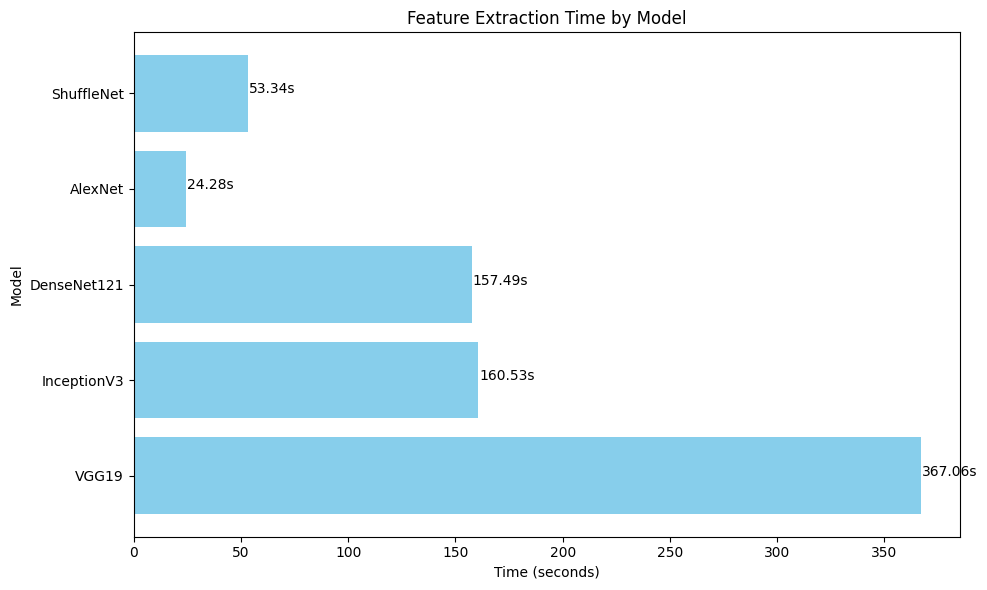

Combined feature shape: (2481, 4800)


In [11]:
plt.figure(figsize=(10, 6))
plt.barh(list(extraction_times.keys()), list(extraction_times.values()), color='skyblue')
plt.xlabel('Time (seconds)')
plt.ylabel('Model')
plt.title('Feature Extraction Time by Model')
for i, v in enumerate(extraction_times.values()):
    plt.text(v + 0.5, i, f"{v:.2f}s")
plt.tight_layout()
plt.savefig('feature_extraction_times.png')
plt.show()

# Concatenate features from all models
X_train_combined = np.concatenate(extracted_features_train, axis=1)
X_test_combined = np.concatenate(extracted_features_test, axis=1)
print(f"Combined feature shape: {X_train_combined.shape}")


In [12]:
print(X_train_combined.shape)
print(X_test_combined.shape)

(2481, 4800)
(621, 4800)


Optimizing 4800 features with GA...
gen	nevals	avg     	max     	min     
0  	20    	0.840918	0.855604	0.823375
1  	16    	0.848432	0.860037	0.826985
2  	18    	0.856431	0.860039	0.845123
3  	12    	0.856875	0.860848	0.844724
4  	14    	0.856693	0.860849	0.84351 
5  	18    	0.858712	0.86165 	0.843516


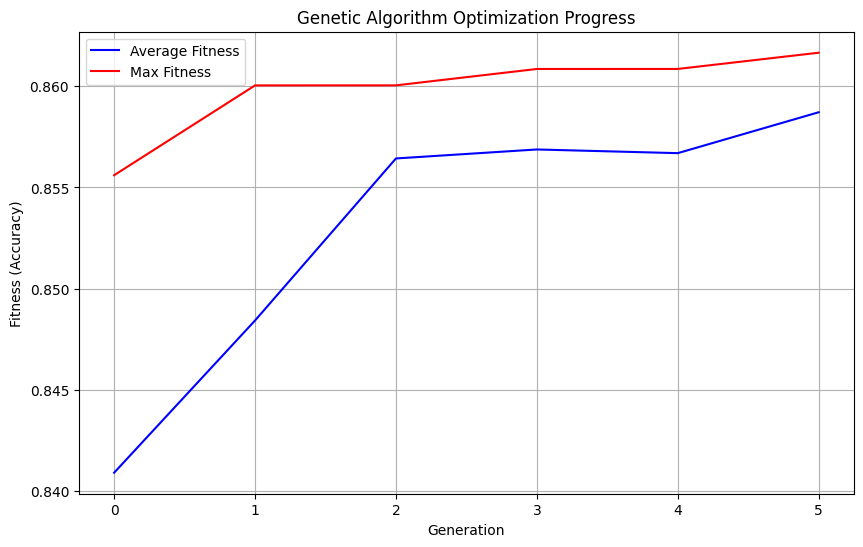


Final feature selection: 2411 features (50.2% of total)

Test set accuracy with selected features: 90.18%


In [13]:

import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

if 'FitnessMax' in dir(creator):
    del creator.FitnessMax
    del creator.Individual

creator.create("FitnessMax", base.Fitness, weights=(1.0,))  
creator.create("Individual", list, fitness=creator.FitnessMax)

def enhanced_fitness(individual):
    selected = np.array(individual).astype(bool)
    num_selected = np.sum(selected)
    if num_selected < 10:
        return (0.0,)
    try:
        model = SVC(kernel='linear', C=1.0, random_state=42)
        scores = cross_val_score(model, X_train_combined[:, selected], y_train, 
                               cv=3, scoring='accuracy', n_jobs=-1)
        penalty = 0.001 * (num_selected / X_train_combined.shape[1])
        return (np.mean(scores) - penalty,)
    
    except ValueError:
        print("Using feature importance fallback...")
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=50, random_state=42)
        model.fit(X_train_combined, y_train)
        importances = model.feature_importances_
        top_features = np.argsort(importances)[-num_selected:]
        selected = np.zeros_like(individual, dtype=bool)
        selected[top_features] = True
        scores = cross_val_score(model, X_train_combined[:, selected], y_train, 
                               cv=3, scoring='accuracy', n_jobs=-1)
        return (np.mean(scores),)


toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
                 toolbox.attr_bool, n=X_train_combined.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", enhanced_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.03)
toolbox.register("select", tools.selTournament, tournsize=5)

population_size = 20
num_generations = 5

population = toolbox.population(n=population_size)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)

print(f"Optimizing {X_train_combined.shape[1]} features with GA...")
pop, logbook = algorithms.eaSimple(population, toolbox, 
                                  cxpb=0.7,  
                                  mutpb=0.3,  
                                  ngen=num_generations, 
                                  stats=stats, 
                                  verbose=True)


plt.figure(figsize=(10, 6))
gen = logbook.select("gen")
avg = logbook.select("avg")
max_fit = logbook.select("max")

plt.plot(gen, avg, 'b-', label="Average Fitness")
plt.plot(gen, max_fit, 'r-', label="Max Fitness")
plt.title('Genetic Algorithm Optimization Progress')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.grid(True)
plt.savefig('ga_optimization_progress.png', dpi=300, bbox_inches='tight')
plt.show()

best_individual = tools.selBest(pop, k=1)[0]
selected_features = np.array(best_individual).astype(bool)
num_selected = selected_features.sum()


if num_selected < 10:
    print("Warning: Suboptimal feature selection detected!")
    print("Falling back to correlation-based selection...")
    from sklearn.feature_selection import mutual_info_classif
    scores = mutual_info_classif(X_train_combined, y_train)
    selected_features = scores >= np.percentile(scores, 90)
    num_selected = selected_features.sum()

print(f"\nFinal feature selection: {num_selected} features "
      f"({num_selected/X_train_combined.shape[1]:.1%} of total)")


X_train_selected = X_train_combined[:, selected_features]
X_test_selected = X_test_combined[:, selected_features]

final_model = SVC(kernel='linear', C=1.0, random_state=42)
final_model.fit(X_train_selected, y_train)
test_accuracy = final_model.score(X_test_selected, y_test)
print(f"\nTest set accuracy with selected features: {test_accuracy:.2%}")


In [14]:
def display_feature_counts(total_features, selected_count):
    print("\nFeature Selection Results:")
    print("="*40)
    print("{:<30} {:<10}".format("Total Features Available", total_features))
    print("{:<30} {:<10}".format("Features Selected", selected_count))
    print("{:<30} {:<10.2f}%".format("Selection Percentage", 
                                    (selected_count/total_features)*100))
    print("="*40)

total_features = X_train_combined.shape[1]
num_selected = selected_features.sum()
display_feature_counts(total_features, num_selected)


if num_selected < 10:
    print("\nFallback Mechanism Activated!")
    print(f"Original selected features: {num_selected}")
    num_selected = selected_features.sum() 
    display_feature_counts(total_features, num_selected)



Feature Selection Results:
Total Features Available       4800      
Features Selected              2411      
Selection Percentage           50.23     %


In [15]:
print(X_test_selected.shape)
print(X_train_selected.shape)

(621, 2411)
(2481, 2411)


In [16]:
def evaluate_model(y_true, y_pred, y_pred_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Calculate AUC if probability scores are available
    auc = 0
    if y_pred_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_pred_proba)
        except:
            auc = 0
    
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'auc': auc
    }

In [17]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Stroke'],
                yticklabels=['Normal', 'Stroke'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{title.lower().replace(" ", "_")}.png')
    plt.show()



Training SVM...


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


SVM Results:
Training time: 25.96 seconds
Accuracy: 0.9018
Precision: 0.8783
Recall: 0.9410
F1 Score: 0.9085
AUC: 0.9486
MSE: 0.0806
MAE: 0.1894
RMSE: 0.2839

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89       299
           1       0.88      0.94      0.91       322

    accuracy                           0.90       621
   macro avg       0.90      0.90      0.90       621
weighted avg       0.90      0.90      0.90       621



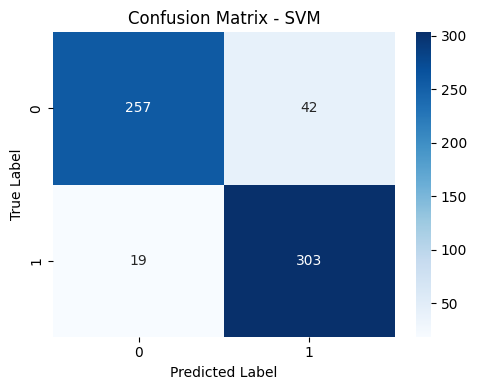

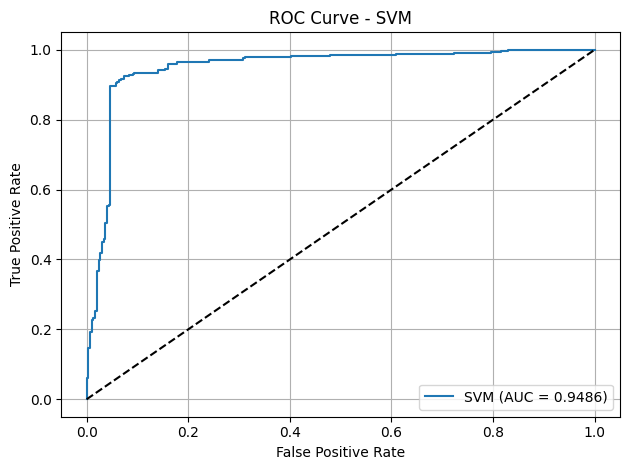


Training Random Forest...


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest Results:
Training time: 15.38 seconds
Accuracy: 0.9243
Precision: 0.9791
Recall: 0.8727
F1 Score: 0.9228
AUC: 0.9794
MSE: 0.0896
MAE: 0.2533
RMSE: 0.2994

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       299
           1       0.98      0.87      0.92       322

    accuracy                           0.92       621
   macro avg       0.93      0.93      0.92       621
weighted avg       0.93      0.92      0.92       621



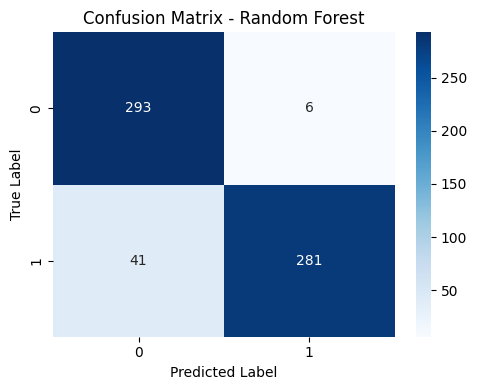

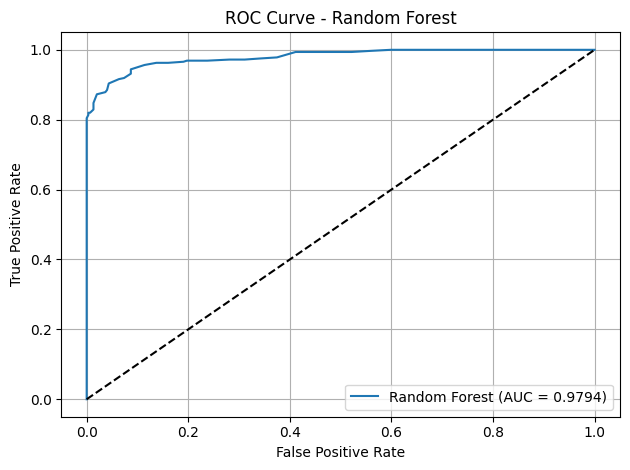


Training Decision Tree...


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Decision Tree Results:
Training time: 12.36 seconds
Accuracy: 0.8374
Precision: 0.8260
Recall: 0.8696
F1 Score: 0.8472
AUC: 0.8361
MSE: 0.1626
MAE: 0.1626
RMSE: 0.4033

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83       299
           1       0.83      0.87      0.85       322

    accuracy                           0.84       621
   macro avg       0.84      0.84      0.84       621
weighted avg       0.84      0.84      0.84       621



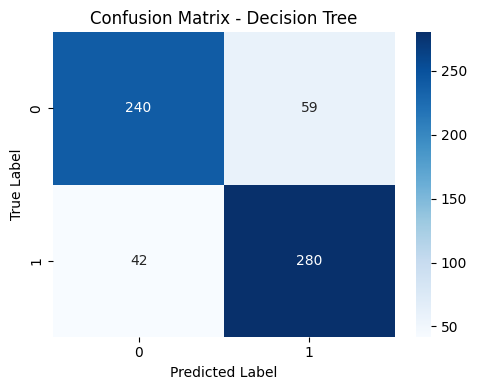

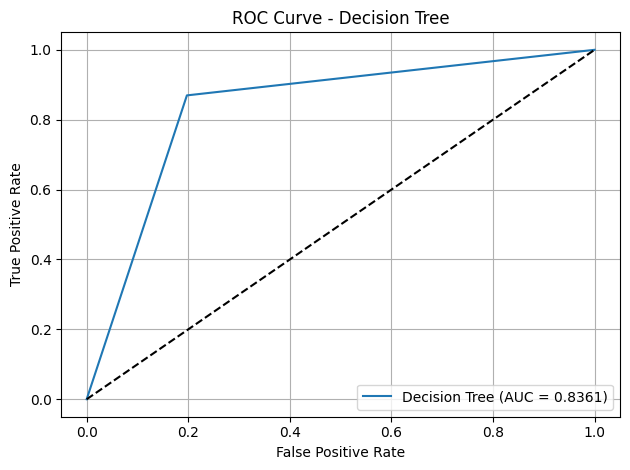


Training Logistic Regression...


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Logistic Regression Results:
Training time: 5.54 seconds
Accuracy: 0.9179
Precision: 0.8950
Recall: 0.9534
F1 Score: 0.9233
AUC: 0.9511
MSE: 0.0738
MAE: 0.1219
RMSE: 0.2716

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91       299
           1       0.90      0.95      0.92       322

    accuracy                           0.92       621
   macro avg       0.92      0.92      0.92       621
weighted avg       0.92      0.92      0.92       621



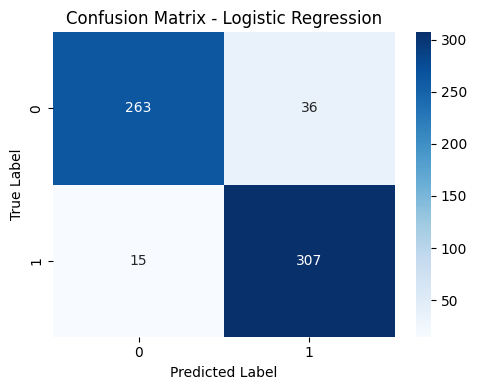

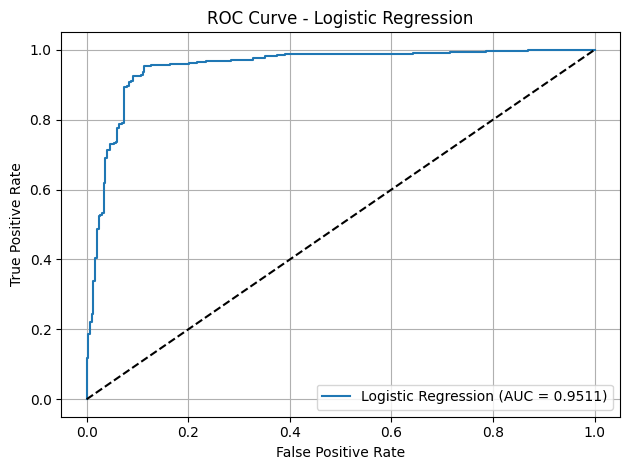


Training Naive Bayes...
Naive Bayes Results:
Training time: 0.16 seconds
Accuracy: 0.6554
Precision: 0.6788
Recall: 0.6366
F1 Score: 0.6571
AUC: 0.7165
MSE: 0.3347
MAE: 0.3424
RMSE: 0.5785

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.68      0.65       299
           1       0.68      0.64      0.66       322

    accuracy                           0.66       621
   macro avg       0.66      0.66      0.66       621
weighted avg       0.66      0.66      0.66       621



C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


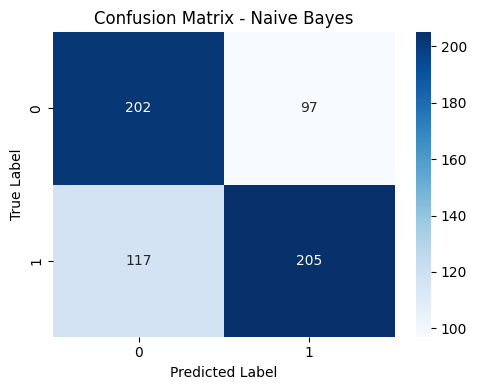

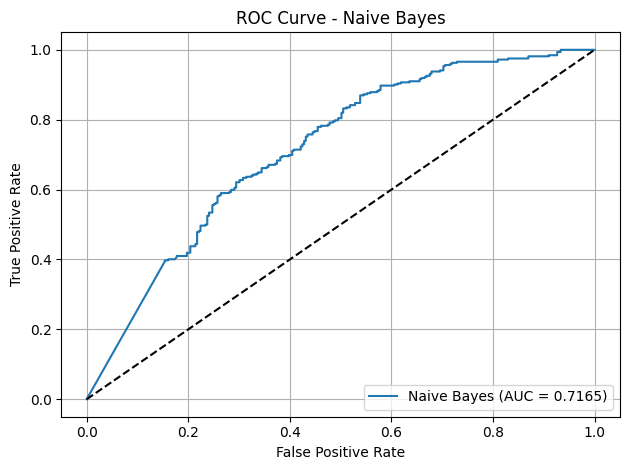


Model Comparison Table:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.901771   0.878261  0.940994  0.908546  0.948618   
1        Random Forest  0.924316   0.979094  0.872671  0.922824  0.979377   
2        Decision Tree  0.837359   0.825959  0.869565  0.847201  0.836120   
3  Logistic Regression  0.917874   0.895044  0.953416  0.923308  0.951079   
4          Naive Bayes  0.655395   0.678808  0.636646  0.657051  0.716457   

   Training Time (s)  
0          25.962622  
1          15.381935  
2          12.355224  
3           5.541396  
4           0.163599  


In [18]:
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, confusion_matrix, 
    mean_squared_error, mean_absolute_error, roc_curve
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

models = {
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB()
}

results = {}
model_metrics = []

def evaluate_model(y_true, y_pred, y_pred_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else 0
    }

    if y_pred_proba is not None:
        metrics['mse'] = mean_squared_error(y_true, y_pred_proba)
        metrics['mae'] = mean_absolute_error(y_true, y_pred_proba)
        metrics['rmse'] = mean_squared_error(y_true, y_pred_proba, squared=False)
    
    return metrics

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

for name, model in models.items():
    start_time = time.time()
    print(f"\nTraining {name}...")
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = evaluate_model(y_test, y_pred, y_pred_proba)
    training_time = time.time() - start_time

    results[name] = {
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'metrics': metrics,
        'training_time': training_time
    }

    print(f"{name} Results:")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    if metrics['auc'] > 0:
        print(f"AUC: {metrics['auc']:.4f}")
    if 'mse' in metrics:
        print(f"MSE: {metrics['mse']:.4f}")
        print(f"MAE: {metrics['mae']:.4f}")
        print(f"RMSE: {metrics['rmse']:.4f}")

    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred, name)

    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["auc"]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    model_metrics.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'AUC': metrics['auc'] if metrics['auc'] > 0 else None,
        'Training Time (s)': training_time
    })

df_metrics = pd.DataFrame(model_metrics)
print("\nModel Comparison Table:")
print(df_metrics)


In [19]:

print(f"Original X_train_selected shape: {X_train_selected.shape}")
print(f"Original X_test_selected shape: {X_test_selected.shape}")

n_features = X_train_selected.shape[1]
timesteps = 1
feature_dim = 1

if n_features > 100:
    timesteps = 10
    feature_dim = n_features // timesteps
    remainder = n_features % timesteps
    
    if remainder > 0:
        padding = np.zeros((X_train_selected.shape[0], timesteps - remainder))
        X_train_selected_padded = np.hstack([X_train_selected, padding])
        padding = np.zeros((X_test_selected.shape[0], timesteps - remainder))
        X_test_selected_padded = np.hstack([X_test_selected, padding])
        n_features = X_train_selected_padded.shape[1]
        feature_dim = n_features // timesteps
        
        X_train_lstm = X_train_selected_padded.reshape(X_train_selected_padded.shape[0], timesteps, feature_dim)
        X_test_lstm = X_test_selected_padded.reshape(X_test_selected_padded.shape[0], timesteps, feature_dim)
    else:
        X_train_lstm = X_train_selected.reshape(X_train_selected.shape[0], timesteps, feature_dim)
        X_test_lstm = X_test_selected.reshape(X_test_selected.shape[0], timesteps, feature_dim)
else:
    X_train_lstm = X_train_selected.reshape(X_train_selected.shape[0], n_features, 1)
    X_test_lstm = X_test_selected.reshape(X_test_selected.shape[0], n_features, 1)
    timesteps = n_features
    feature_dim = 1

print(f"Reshaped X_train_lstm shape: {X_train_lstm.shape}")
print(f"Reshaped X_test_lstm shape: {X_test_lstm.shape}")


Original X_train_selected shape: (2481, 2411)
Original X_test_selected shape: (621, 2411)
Reshaped X_train_lstm shape: (2481, 10, 242)
Reshaped X_test_lstm shape: (621, 10, 242)



Fold 1

Epoch 71: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 77: ReduceLROnPlateau reducing learning rate to 1e-05.
Final Training Loss: 0.3704
Final Validation Loss: 0.8492
Final Training Accuracy: 0.9990
Final Validation Accuracy: 0.9095
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


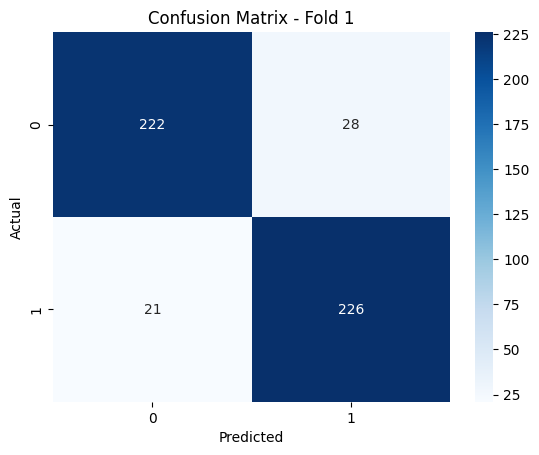

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       250
           1       0.89      0.91      0.90       247

    accuracy                           0.90       497
   macro avg       0.90      0.90      0.90       497
weighted avg       0.90      0.90      0.90       497


Fold 2
Final Training Loss: 0.2554
Final Validation Loss: 0.2600
Final Training Accuracy: 0.9995
Final Validation Accuracy: 0.9960
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


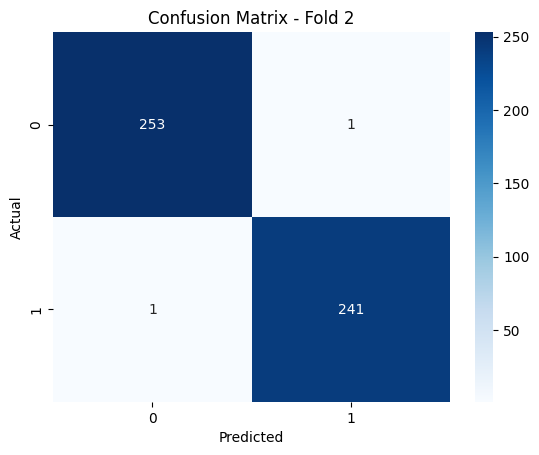

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       242

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 3
Final Training Loss: 0.1855
Final Validation Loss: 0.1847
Final Training Accuracy: 0.9995
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


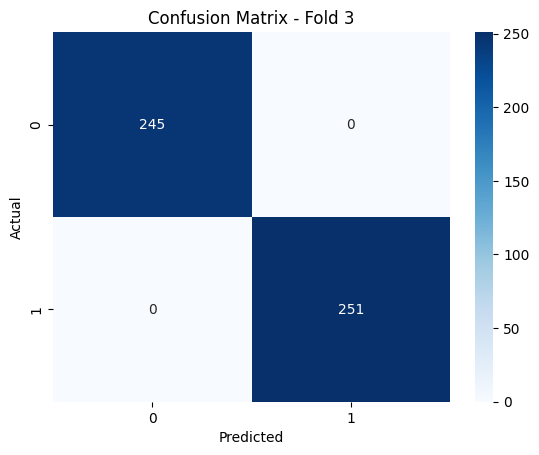

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00       251

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 4
Final Training Loss: 0.1566
Final Validation Loss: 0.1552
Final Training Accuracy: 0.9985
Final Validation Accuracy: 0.9980
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


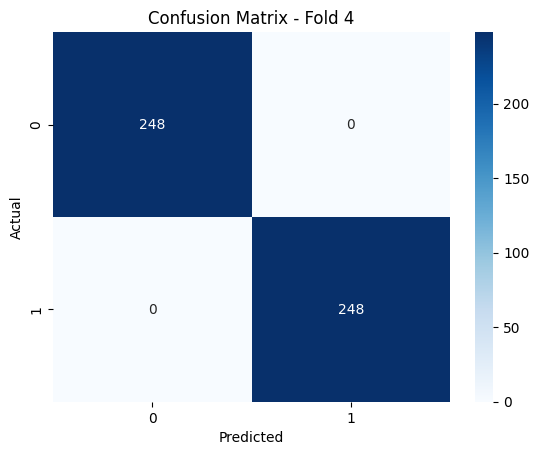

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       248

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 5
Final Training Loss: 0.1318
Final Validation Loss: 0.1322
Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


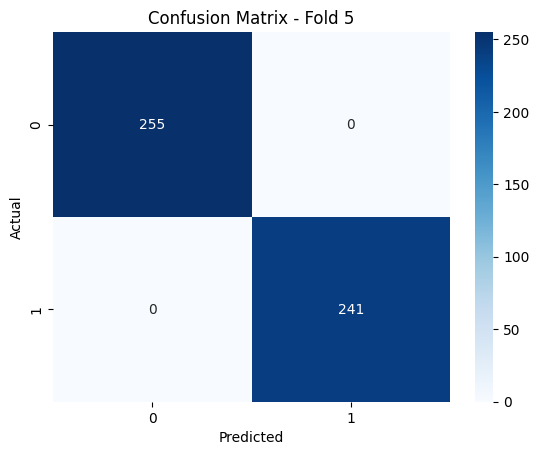

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       1.00      1.00      1.00       241

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Optimized BiLSTM Average Metrics:
Accuracy: 0.9795
Precision: 0.9771
Recall: 0.9822
F1 Score: 0.9796
AUC: 0.9922

Mean Final Training & Validation Metrics:
Mean Final Training Loss: 0.2200
Mean Final Validation Loss: 0.3163
Mean Final Training Accuracy: 0.9993
Mean Final Validation Accuracy: 0.9807


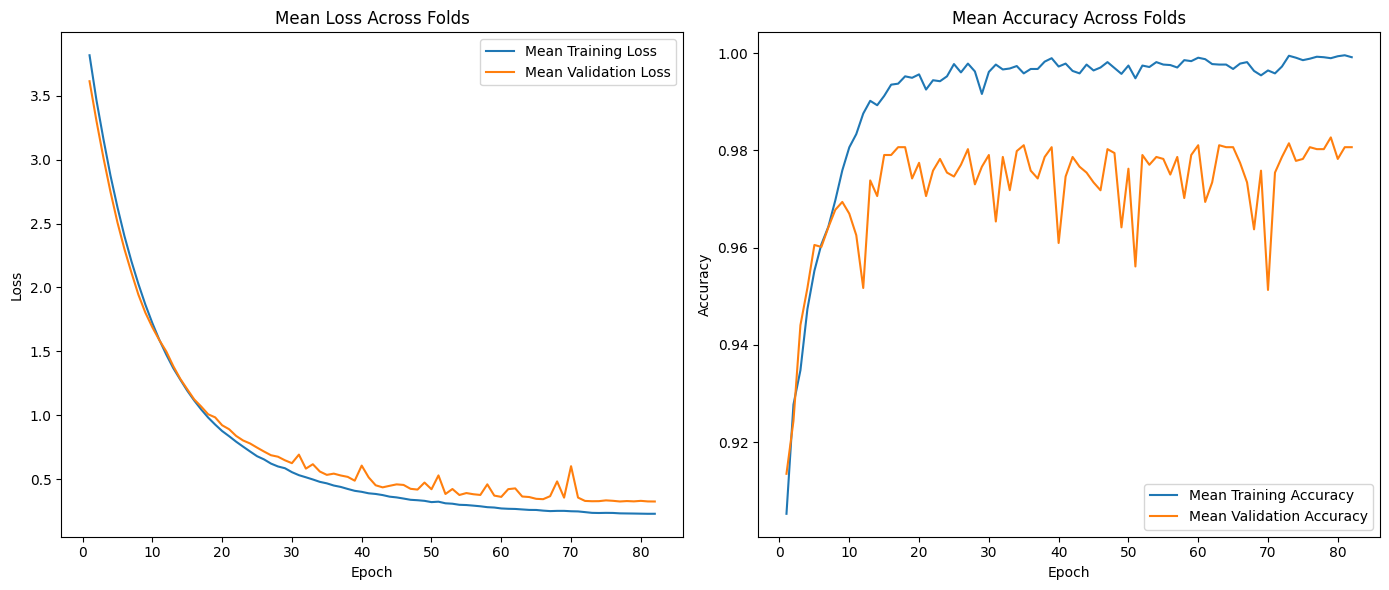

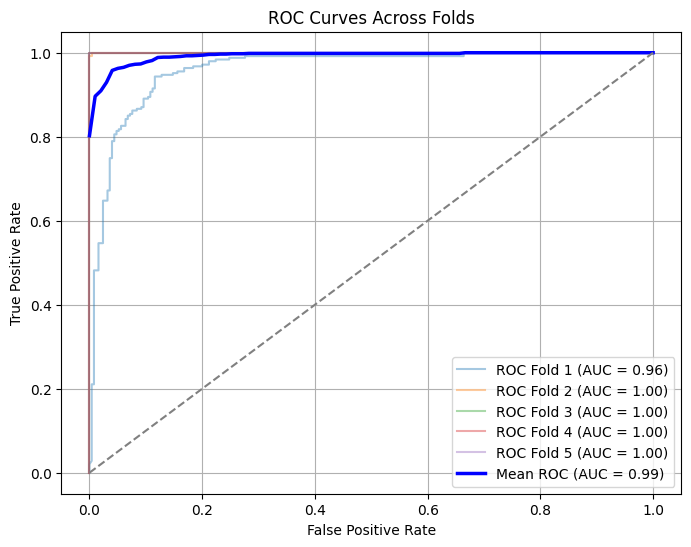

                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.901771   0.878261  0.940994  0.908546  0.948618   
1        Random Forest  0.924316   0.979094  0.872671  0.922824  0.979377   
2        Decision Tree  0.837359   0.825959  0.869565  0.847201  0.836120   
3  Logistic Regression  0.917874   0.895044  0.953416  0.923308  0.951079   
4          Naive Bayes  0.655395   0.678808  0.636646  0.657051  0.716457   

   Training Time (s)  
0          25.962622  
1          15.381935  
2          12.355224  
3           5.541396  
4           0.163599  

Optimized BiLSTM Average Metrics:
Accuracy: 0.9795
Precision: 0.9771
Recall: 0.9822
F1 Score: 0.9796
AUC: 0.9922
Training Time (s): 1354.8800

Updated Model Metrics Table:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.901771   0.878261  0.940994  0.908546  0.948618   
1        Random Forest  0.924316   0.979094  0.872671  0.922824  0.97937

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, BatchNormalization
import seaborn as sns
import time
start_time = time.time()
model_metrics = [m for m in model_metrics if m['Model'] != 'BiLSTM']

bilstm_model = Sequential([
    Input(shape=(timesteps, feature_dim)),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    Dropout(0.3),
    BatchNormalization(),

    Bidirectional(LSTM(128, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
    Dropout(0.3),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
bilstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_bilstm_metrics = []
all_fpr, all_tpr, all_auc = [], [], []
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
fold = 1
for train_idx, val_idx in kf.split(X_train_lstm):
    print(f"\nFold {fold}")
    
    X_tr, X_val = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    history = bilstm_model.fit(
        X_tr, y_tr,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    train_loss_all.append(history.history['loss'])
    val_loss_all.append(history.history['val_loss'])
    train_acc_all.append(history.history['accuracy'])
    val_acc_all.append(history.history['val_accuracy'])

    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    y_pred_val_proba = bilstm_model.predict(X_val).flatten()
    fpr, tpr, _ = roc_curve(y_val, y_pred_val_proba)
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

    y_pred_val = (y_pred_val_proba > 0.5).astype(int).flatten()

    metrics = evaluate_model(y_val, y_pred_val, y_pred_val_proba)
    cv_bilstm_metrics.append({
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'AUC': metrics['auc']
    })

    print("Confusion Matrix:")
    cm = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_val, y_pred_val))

    fold += 1
training_time = time.time() - start_time
mean_bilstm_metrics = {
    'Model': 'BiLSTM',
    'Accuracy': np.mean([m['Accuracy'] for m in cv_bilstm_metrics]),
    'Precision': np.mean([m['Precision'] for m in cv_bilstm_metrics]),
    'Recall': np.mean([m['Recall'] for m in cv_bilstm_metrics]),
    'F1 Score': np.mean([m['F1 Score'] for m in cv_bilstm_metrics]),
    'AUC': np.mean([m['AUC'] for m in cv_bilstm_metrics])
}

print("\nOptimized BiLSTM Average Metrics:")
print(f"Accuracy: {mean_bilstm_metrics['Accuracy']:.4f}")
print(f"Precision: {mean_bilstm_metrics['Precision']:.4f}")
print(f"Recall: {mean_bilstm_metrics['Recall']:.4f}")
print(f"F1 Score: {mean_bilstm_metrics['F1 Score']:.4f}")
print(f"AUC: {mean_bilstm_metrics['AUC']:.4f}")

mean_final_train_loss = np.mean([losses[-1] for losses in train_loss_all])
mean_final_val_loss = np.mean([losses[-1] for losses in val_loss_all])
mean_final_train_acc = np.mean([acc[-1] for acc in train_acc_all])
mean_final_val_acc = np.mean([acc[-1] for acc in val_acc_all])

print("\nMean Final Training & Validation Metrics:")
print(f"Mean Final Training Loss: {mean_final_train_loss:.4f}")
print(f"Mean Final Validation Loss: {mean_final_val_loss:.4f}")
print(f"Mean Final Training Accuracy: {mean_final_train_acc:.4f}")
print(f"Mean Final Validation Accuracy: {mean_final_val_acc:.4f}")

min_epochs = min(map(len, train_loss_all))
train_loss_all = np.array([x[:min_epochs] for x in train_loss_all])
val_loss_all = np.array([x[:min_epochs] for x in val_loss_all])
train_acc_all = np.array([x[:min_epochs] for x in train_acc_all])
val_acc_all = np.array([x[:min_epochs] for x in val_acc_all])

# Plot Loss and Accuracy
epochs = range(1, min_epochs + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, np.mean(train_loss_all, axis=0), label='Mean Training Loss')
plt.plot(epochs, np.mean(val_loss_all, axis=0), label='Mean Validation Loss')
plt.title('Mean Loss Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, np.mean(train_acc_all, axis=0), label='Mean Training Accuracy')
plt.plot(epochs, np.mean(val_acc_all, axis=0), label='Mean Validation Accuracy')
plt.title('Mean Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'ROC Fold {i+1} (AUC = {all_auc[i]:.2f})', alpha=0.4)

mean_fpr = np.linspace(0, 1, 100)
interp_tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)]
mean_tpr = np.mean(interp_tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2.5, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Across Folds')
plt.legend()
plt.grid(True)
plt.show()

print(df_metrics)
mean_bilstm_metrics = {
    'Model': 'BiLSTM',
    'Accuracy': np.mean([m['Accuracy'] for m in cv_bilstm_metrics]),
    'Precision': np.mean([m['Precision'] for m in cv_bilstm_metrics]),
    'Recall': np.mean([m['Recall'] for m in cv_bilstm_metrics]),
    'F1 Score': np.mean([m['F1 Score'] for m in cv_bilstm_metrics]),
    'AUC': np.mean([m['AUC'] for m in cv_bilstm_metrics]),
    'Training Time (s)': round(training_time, 2)
}

# Print final summary
print("\nOptimized BiLSTM Average Metrics:")
for k, v in mean_bilstm_metrics.items():
    if k != "Model" and v is not None:
        print(f"{k}: {v:.4f}")

# Append to model_metrics
model_metrics.append(mean_bilstm_metrics)
df_metrics = pd.DataFrame(model_metrics)
print("\nUpdated Model Metrics Table:")
print(df_metrics)


Fold 1

Epoch 52: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 59: ReduceLROnPlateau reducing learning rate to 1e-05.
Final Training Loss: 0.4595
Final Validation Loss: 1.0009
Final Training Accuracy: 0.9985
Final Validation Accuracy: 0.8913
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


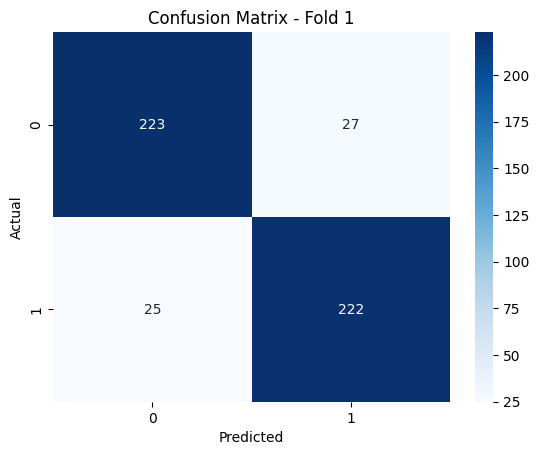

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       250
           1       0.89      0.90      0.90       247

    accuracy                           0.90       497
   macro avg       0.90      0.90      0.90       497
weighted avg       0.90      0.90      0.90       497


Fold 2
Final Training Loss: 0.3999
Final Validation Loss: 0.3919
Final Training Accuracy: 0.9940
Final Validation Accuracy: 0.9960
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


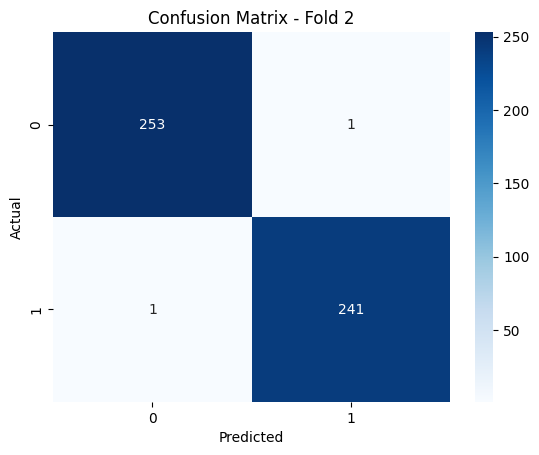

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       242

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 3
Final Training Loss: 0.3235
Final Validation Loss: 0.3185
Final Training Accuracy: 0.9980
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


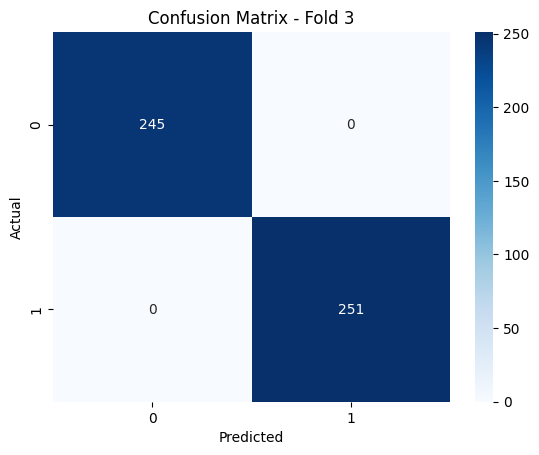

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00       251

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 4
Final Training Loss: 0.2727
Final Validation Loss: 0.2693
Final Training Accuracy: 0.9975
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


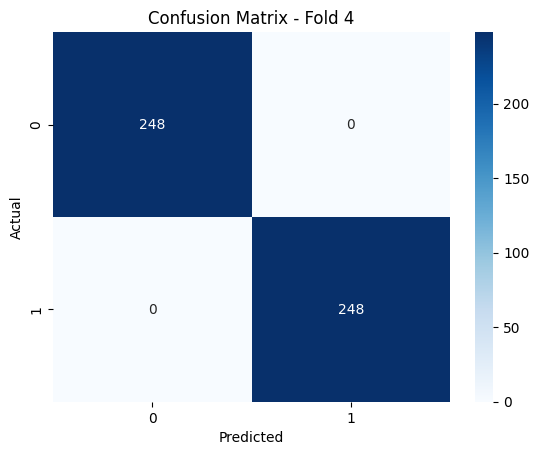

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       248

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 5
Final Training Loss: 0.2316
Final Validation Loss: 0.2293
Final Training Accuracy: 0.9995
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


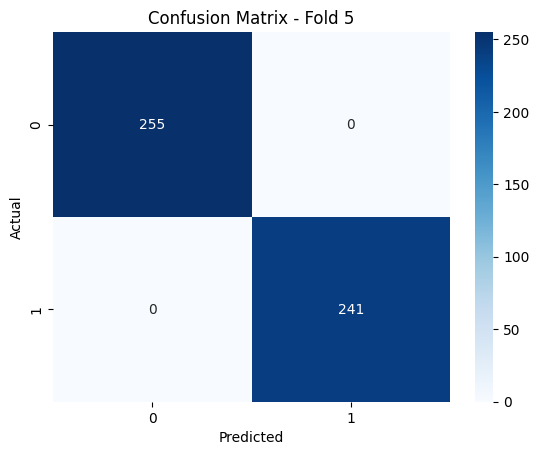

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       1.00      1.00      1.00       241

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


LSTM Average Metrics:
Accuracy: 0.9783
Precision: 0.9775
Recall: 0.9789
F1 Score: 0.9782
AUC: 0.9892

Mean Final Training & Validation Metrics:
Mean Final Training Loss: 0.3374
Mean Final Validation Loss: 0.4420
Mean Final Training Accuracy: 0.9975
Mean Final Validation Accuracy: 0.9775


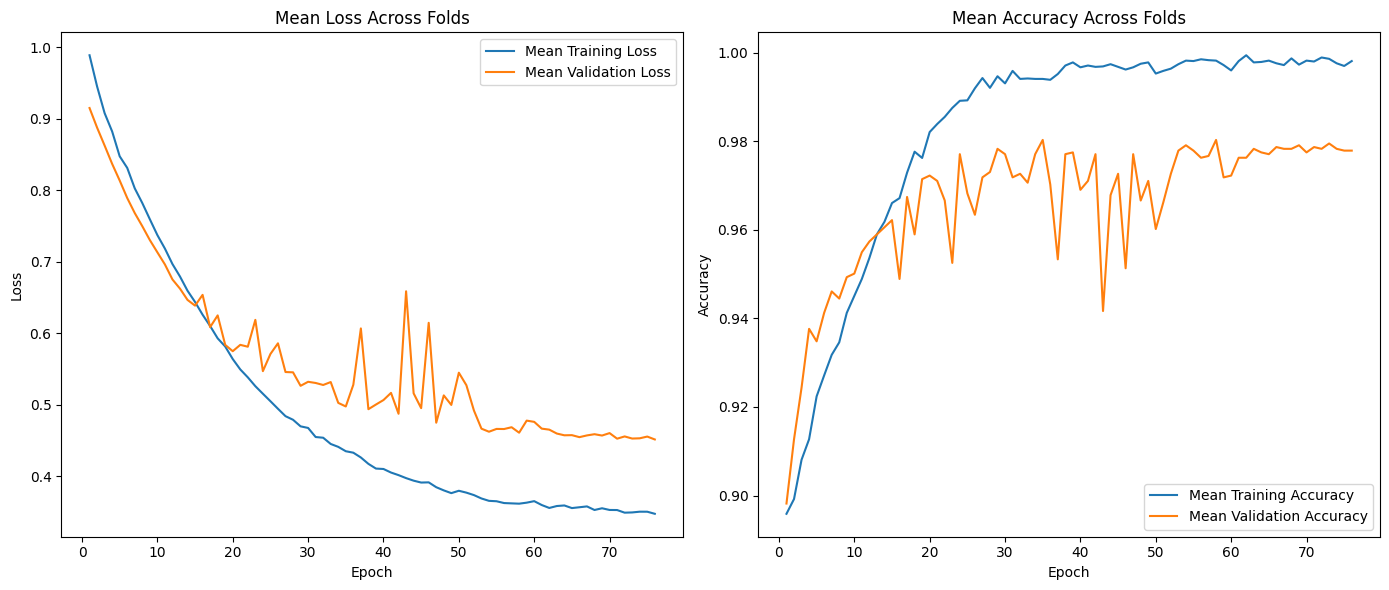

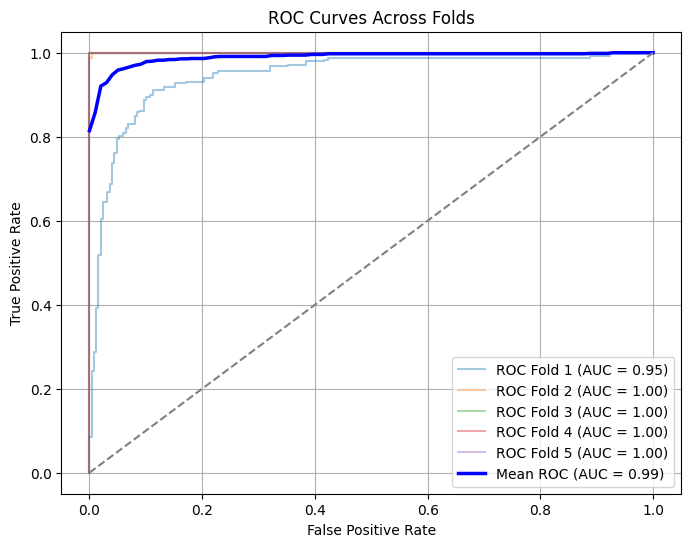


Final Classification Report on Entire Training Data:
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1252
           1       1.00      1.00      1.00      1229

    accuracy                           1.00      2481
   macro avg       1.00      1.00      1.00      2481
weighted avg       1.00      1.00      1.00      2481



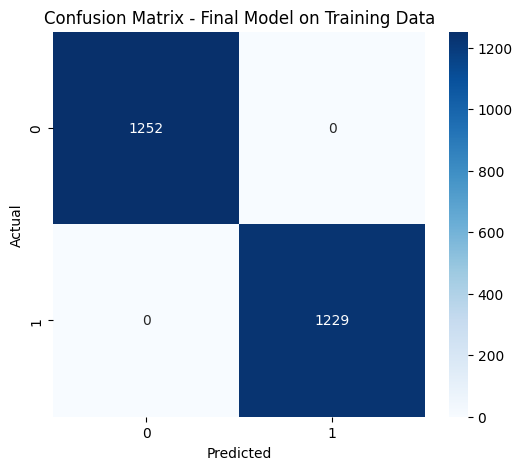


Updated Model Metrics Table:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.901771   0.878261  0.940994  0.908546  0.948618   
1        Random Forest  0.924316   0.979094  0.872671  0.922824  0.979377   
2        Decision Tree  0.837359   0.825959  0.869565  0.847201  0.836120   
3  Logistic Regression  0.917874   0.895044  0.953416  0.923308  0.951079   
4          Naive Bayes  0.655395   0.678808  0.636646  0.657051  0.716457   
5               BiLSTM  0.979475   0.977126  0.982170  0.979613  0.992159   
6                 LSTM  0.978268   0.977487  0.978931  0.978206  0.989195   

   Training Time (s)  
0          25.962622  
1          15.381935  
2          12.355224  
3           5.541396  
4           0.163599  
5        1354.880000  
6         501.849496  


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
start_time = time.time() 
# LSTM Model Architecture with lighter filters
lstm_model = Sequential([
    Input(shape=(timesteps, feature_dim)),
    LSTM(96, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.006)),  
    Dropout(0.35),  # Reduced dropout
    BatchNormalization(),

    LSTM(48, kernel_regularizer=tf.keras.regularizers.l2(0.006)),  
    Dropout(0.25),  # Reduced dropout
    BatchNormalization(),

    Dense(48, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

# Using Adam optimizer with a smaller learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

# Training with 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_lstm_metrics = []
all_fpr, all_tpr, all_auc = [], [], []
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

fold = 1
for train_idx, val_idx in kf.split(X_train_lstm):
    print(f"\nFold {fold}")
    
    X_tr, X_val = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    history = lstm_model.fit(
        X_tr, y_tr,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    train_loss_all.append(history.history['loss'])
    val_loss_all.append(history.history['val_loss'])
    train_acc_all.append(history.history['accuracy'])
    val_acc_all.append(history.history['val_accuracy'])

    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    y_pred_val_proba = lstm_model.predict(X_val).flatten()
    fpr, tpr, _ = roc_curve(y_val, y_pred_val_proba)
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

    y_pred_val = (y_pred_val_proba > 0.5).astype(int).flatten()

    metrics = evaluate_model(y_val, y_pred_val, y_pred_val_proba)
    cv_lstm_metrics.append({
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'AUC': metrics['auc']
    })

    print("Confusion Matrix:")
    cm = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_val, y_pred_val))

    fold += 1
training_time = time.time() - start_time

mean_lstm_metrics = {
    'Model': 'LSTM',
    'Accuracy': np.mean([m['Accuracy'] for m in cv_lstm_metrics]),
    'Precision': np.mean([m['Precision'] for m in cv_lstm_metrics]),
    'Recall': np.mean([m['Recall'] for m in cv_lstm_metrics]),
    'F1 Score': np.mean([m['F1 Score'] for m in cv_lstm_metrics]),
    'AUC': np.mean([m['AUC'] for m in cv_lstm_metrics]),
    'Training Time (s)': training_time 
}

print("\nLSTM Average Metrics:")
print(f"Accuracy: {mean_lstm_metrics['Accuracy']:.4f}")
print(f"Precision: {mean_lstm_metrics['Precision']:.4f}")
print(f"Recall: {mean_lstm_metrics['Recall']:.4f}")
print(f"F1 Score: {mean_lstm_metrics['F1 Score']:.4f}")
print(f"AUC: {mean_lstm_metrics['AUC']:.4f}")

mean_final_train_loss = np.mean([losses[-1] for losses in train_loss_all])
mean_final_val_loss = np.mean([losses[-1] for losses in val_loss_all])
mean_final_train_acc = np.mean([acc[-1] for acc in train_acc_all])
mean_final_val_acc = np.mean([acc[-1] for acc in val_acc_all])

print("\nMean Final Training & Validation Metrics:")
print(f"Mean Final Training Loss: {mean_final_train_loss:.4f}")
print(f"Mean Final Validation Loss: {mean_final_val_loss:.4f}")
print(f"Mean Final Training Accuracy: {mean_final_train_acc:.4f}")
print(f"Mean Final Validation Accuracy: {mean_final_val_acc:.4f}")

min_epochs = min(map(len, train_loss_all))
train_loss_all = np.array([x[:min_epochs] for x in train_loss_all])
val_loss_all = np.array([x[:min_epochs] for x in val_loss_all])
train_acc_all = np.array([x[:min_epochs] for x in train_acc_all])
val_acc_all = np.array([x[:min_epochs] for x in val_acc_all])

# Plot Loss and Accuracy
epochs = range(1, min_epochs + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, np.mean(train_loss_all, axis=0), label='Mean Training Loss')
plt.plot(epochs, np.mean(val_loss_all, axis=0), label='Mean Validation Loss')
plt.title('Mean Loss Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, np.mean(train_acc_all, axis=0), label='Mean Training Accuracy')
plt.plot(epochs, np.mean(val_acc_all, axis=0), label='Mean Validation Accuracy')
plt.title('Mean Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'ROC Fold {i+1} (AUC = {all_auc[i]:.2f})', alpha=0.4)

mean_fpr = np.linspace(0, 1, 100)
interp_tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)]
mean_tpr = np.mean(interp_tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2.5, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# Final Classification Report and Confusion Matrix on the entire training data
print("\nFinal Classification Report on Entire Training Data:")
y_pred_train_proba = lstm_model.predict(X_train_lstm).flatten()
y_pred_train = (y_pred_train_proba > 0.5).astype(int).flatten()

print(classification_report(y_train, y_pred_train))

cm_final = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final Model on Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
model_metrics = [m for m in model_metrics if m['Model'] != 'LSTM']
# Append to model_metrics
model_metrics.append(mean_lstm_metrics)
df_metrics = pd.DataFrame(model_metrics)
print("\nUpdated Model Metrics Table:")
print(df_metrics)



Fold 1

Epoch 78: ReduceLROnPlateau reducing learning rate to 1e-05.
Final Training Loss: 0.6477
Final Validation Loss: 1.4237
Final Training Accuracy: 0.9985
Final Validation Accuracy: 0.8330
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


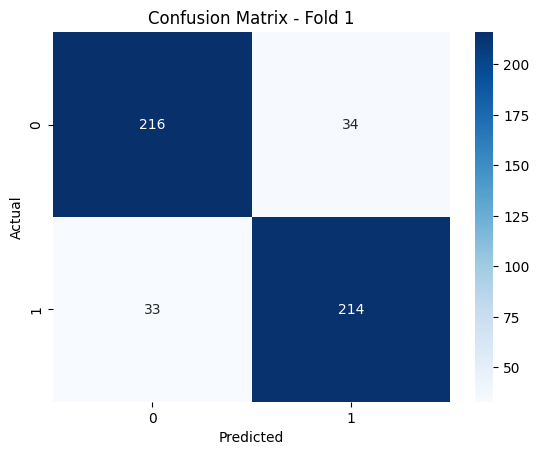

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       250
           1       0.86      0.87      0.86       247

    accuracy                           0.87       497
   macro avg       0.87      0.87      0.87       497
weighted avg       0.87      0.87      0.87       497


Fold 2
Final Training Loss: 0.5462
Final Validation Loss: 0.6016
Final Training Accuracy: 0.9990
Final Validation Accuracy: 0.9839
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


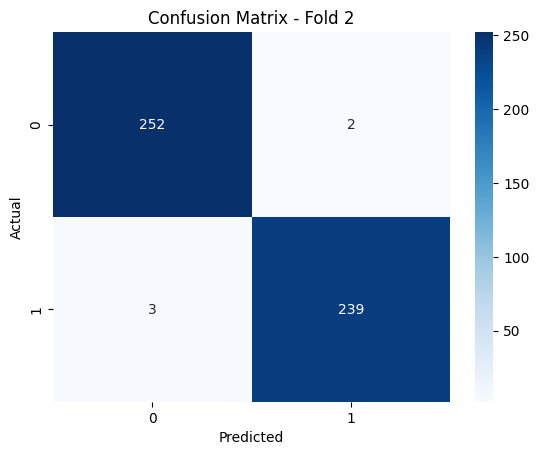

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       254
           1       0.99      0.99      0.99       242

    accuracy                           0.99       496
   macro avg       0.99      0.99      0.99       496
weighted avg       0.99      0.99      0.99       496


Fold 3
Final Training Loss: 0.4398
Final Validation Loss: 0.4352
Final Training Accuracy: 0.9980
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


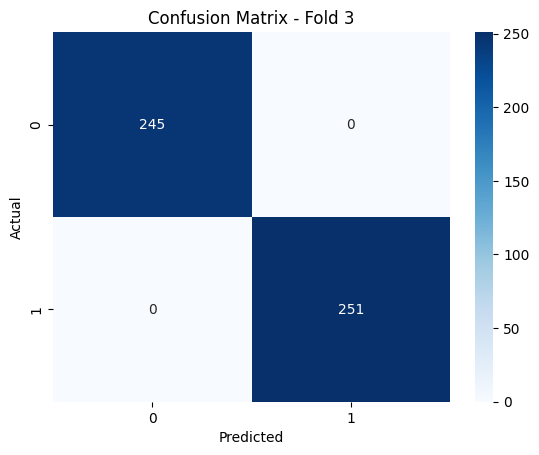

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00       251

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 4
Final Training Loss: 0.3741
Final Validation Loss: 0.3655
Final Training Accuracy: 0.9960
Final Validation Accuracy: 0.9980
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


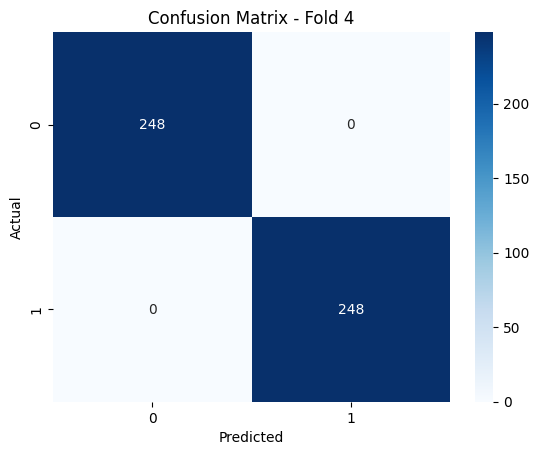

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       248

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 5
Final Training Loss: 0.3231
Final Validation Loss: 0.3110
Final Training Accuracy: 0.9965
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix:


C:\Users\sadhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


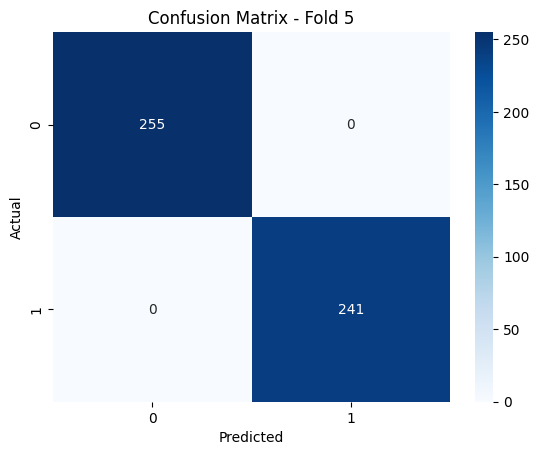

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       1.00      1.00      1.00       241

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


LSTM Average Metrics:
Accuracy: 0.9710
Precision: 0.9709
Recall: 0.9708
F1 Score: 0.9709
AUC: 0.9846

Mean Final Training & Validation Metrics:
Mean Final Training Loss: 0.4662
Mean Final Validation Loss: 0.6274
Mean Final Training Accuracy: 0.9976
Mean Final Validation Accuracy: 0.9630


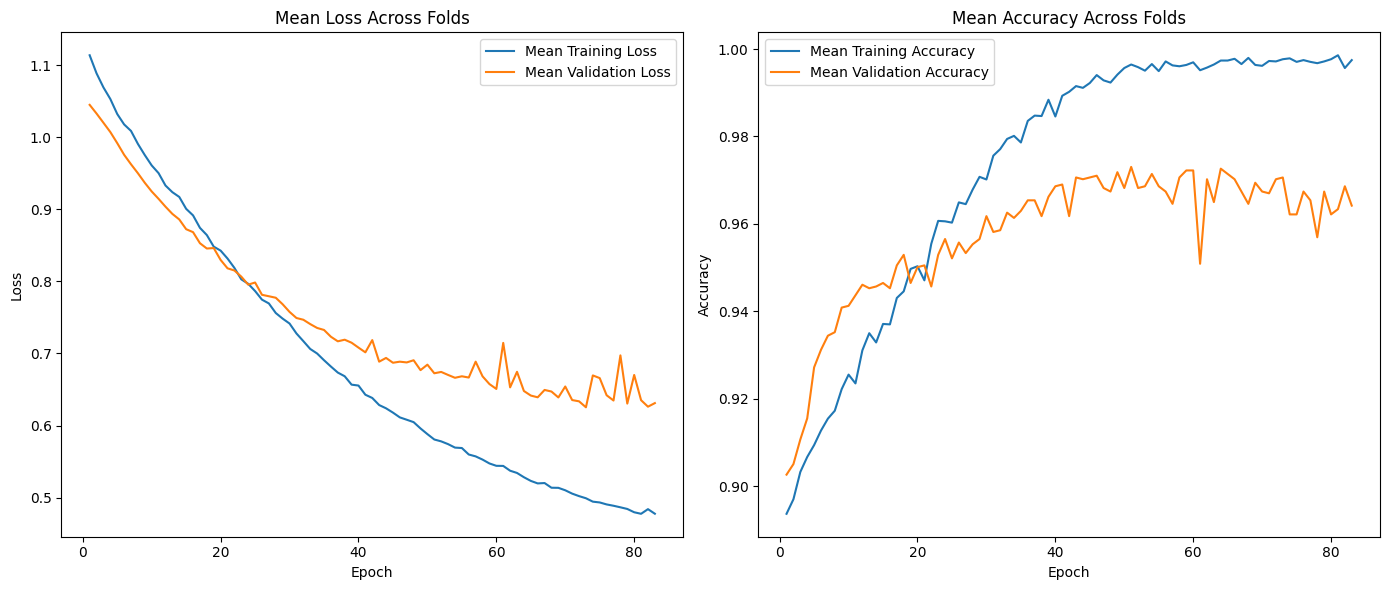

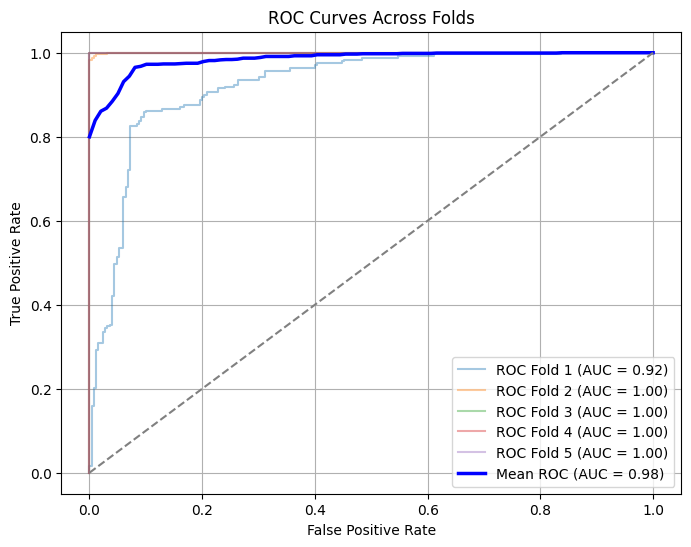


Final Classification Report on Entire Training Data:
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1252
           1       1.00      1.00      1.00      1229

    accuracy                           1.00      2481
   macro avg       1.00      1.00      1.00      2481
weighted avg       1.00      1.00      1.00      2481



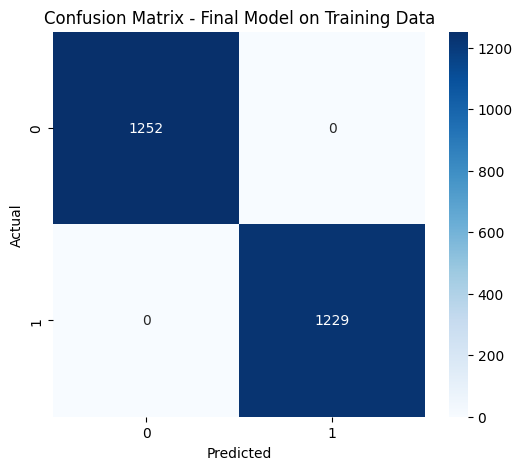


Updated Model Metrics Table:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.901771   0.878261  0.940994  0.908546  0.948618   
1        Random Forest  0.924316   0.979094  0.872671  0.922824  0.979377   
2        Decision Tree  0.837359   0.825959  0.869565  0.847201  0.836120   
3  Logistic Regression  0.917874   0.895044  0.953416  0.923308  0.951079   
4          Naive Bayes  0.655395   0.678808  0.636646  0.657051  0.716457   
5               BiLSTM  0.979475   0.977126  0.982170  0.979613  0.992159   
6                 LSTM  0.971022   0.970921  0.970800  0.970859  0.984550   

   Training Time (s)  
0          25.962622  
1          15.381935  
2          12.355224  
3           5.541396  
4           0.163599  
5        1354.880000  
6         497.622994  


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
start_time = time.time() 
lstm_model = Sequential([
        Input(shape=(timesteps, feature_dim)),
        LSTM(96, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.006)),
        Dropout(0.4),
        BatchNormalization(),

        LSTM(48, kernel_regularizer=tf.keras.regularizers.l2(0.006)),
        Dropout(0.3),
        BatchNormalization(),

        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_lstm_metrics = []
all_fpr, all_tpr, all_auc = [], [], []
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

fold = 1
for train_idx, val_idx in kf.split(X_train_lstm):
    print(f"\nFold {fold}")
    
    X_tr, X_val = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    history = lstm_model.fit(
        X_tr, y_tr,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    train_loss_all.append(history.history['loss'])
    val_loss_all.append(history.history['val_loss'])
    train_acc_all.append(history.history['accuracy'])
    val_acc_all.append(history.history['val_accuracy'])

    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    y_pred_val_proba = lstm_model.predict(X_val).flatten()
    fpr, tpr, _ = roc_curve(y_val, y_pred_val_proba)
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

    y_pred_val = (y_pred_val_proba > 0.5).astype(int).flatten()

    metrics = evaluate_model(y_val, y_pred_val, y_pred_val_proba)
    cv_lstm_metrics.append({
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'AUC': metrics['auc']
    })
    print("Confusion Matrix:")
    cm = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_val, y_pred_val))

    fold += 1
training_time = time.time() - start_time
mean_lstm_metrics = {
    'Model': 'LSTM',
    'Accuracy': np.mean([m['Accuracy'] for m in cv_lstm_metrics]),
    'Precision': np.mean([m['Precision'] for m in cv_lstm_metrics]),
    'Recall': np.mean([m['Recall'] for m in cv_lstm_metrics]),
    'F1 Score': np.mean([m['F1 Score'] for m in cv_lstm_metrics]),
    'AUC': np.mean([m['AUC'] for m in cv_lstm_metrics]),
    'Training Time (s)': training_time 
}

print("\nLSTM Average Metrics:")
print(f"Accuracy: {mean_lstm_metrics['Accuracy']:.4f}")
print(f"Precision: {mean_lstm_metrics['Precision']:.4f}")
print(f"Recall: {mean_lstm_metrics['Recall']:.4f}")
print(f"F1 Score: {mean_lstm_metrics['F1 Score']:.4f}")
print(f"AUC: {mean_lstm_metrics['AUC']:.4f}")

mean_final_train_loss = np.mean([losses[-1] for losses in train_loss_all])
mean_final_val_loss = np.mean([losses[-1] for losses in val_loss_all])
mean_final_train_acc = np.mean([acc[-1] for acc in train_acc_all])
mean_final_val_acc = np.mean([acc[-1] for acc in val_acc_all])

print("\nMean Final Training & Validation Metrics:")
print(f"Mean Final Training Loss: {mean_final_train_loss:.4f}")
print(f"Mean Final Validation Loss: {mean_final_val_loss:.4f}")
print(f"Mean Final Training Accuracy: {mean_final_train_acc:.4f}")
print(f"Mean Final Validation Accuracy: {mean_final_val_acc:.4f}")

min_epochs = min(map(len, train_loss_all))
train_loss_all = np.array([x[:min_epochs] for x in train_loss_all])
val_loss_all = np.array([x[:min_epochs] for x in val_loss_all])
train_acc_all = np.array([x[:min_epochs] for x in train_acc_all])
val_acc_all = np.array([x[:min_epochs] for x in val_acc_all])

# Plot Loss and Accuracy
epochs = range(1, min_epochs + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, np.mean(train_loss_all, axis=0), label='Mean Training Loss')
plt.plot(epochs, np.mean(val_loss_all, axis=0), label='Mean Validation Loss')
plt.title('Mean Loss Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, np.mean(train_acc_all, axis=0), label='Mean Training Accuracy')
plt.plot(epochs, np.mean(val_acc_all, axis=0), label='Mean Validation Accuracy')
plt.title('Mean Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'ROC Fold {i+1} (AUC = {all_auc[i]:.2f})', alpha=0.4)

mean_fpr = np.linspace(0, 1, 100)
interp_tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)]
mean_tpr = np.mean(interp_tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2.5, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Across Folds')
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal Classification Report on Entire Training Data:")
y_pred_train_proba = lstm_model.predict(X_train_lstm).flatten()
y_pred_train = (y_pred_train_proba > 0.5).astype(int).flatten()

print(classification_report(y_train, y_pred_train))

cm_final = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final Model on Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
model_metrics = [m for m in model_metrics if m['Model'] != 'LSTM']
model_metrics.append(mean_lstm_metrics)
df_metrics = pd.DataFrame(model_metrics)
print("\nUpdated Model Metrics Table:")
print(df_metrics)


In [28]:
results_df = pd.DataFrame(model_metrics)

# Check if the DataFrame is correctly created
print(results_df.head())

                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.901771   0.878261  0.940994  0.908546  0.948618   
1        Random Forest  0.924316   0.979094  0.872671  0.922824  0.979377   
2        Decision Tree  0.837359   0.825959  0.869565  0.847201  0.836120   
3  Logistic Regression  0.917874   0.895044  0.953416  0.923308  0.951079   
4          Naive Bayes  0.655395   0.678808  0.636646  0.657051  0.716457   

   Training Time (s)  
0          25.962622  
1          15.381935  
2          12.355224  
3           5.541396  
4           0.163599  


In [29]:
print(model_metrics)

[{'Model': 'SVM', 'Accuracy': 0.9017713365539453, 'Precision': 0.8782608695652174, 'Recall': 0.9409937888198758, 'F1 Score': 0.9085457271364318, 'AUC': 0.9486175450258626, 'Training Time (s)': 25.96262216567993}, {'Model': 'Random Forest', 'Accuracy': 0.9243156199677939, 'Precision': 0.9790940766550522, 'Recall': 0.8726708074534162, 'F1 Score': 0.922824302134647, 'AUC': 0.9793774278651406, 'Training Time (s)': 15.381934642791748}, {'Model': 'Decision Tree', 'Accuracy': 0.8373590982286635, 'Precision': 0.8259587020648967, 'Recall': 0.8695652173913043, 'F1 Score': 0.8472012102874432, 'AUC': 0.8361204013377926, 'Training Time (s)': 12.355224132537842}, {'Model': 'Logistic Regression', 'Accuracy': 0.9178743961352657, 'Precision': 0.8950437317784257, 'Recall': 0.953416149068323, 'F1 Score': 0.9233082706766917, 'AUC': 0.9510791665801118, 'Training Time (s)': 5.541395902633667}, {'Model': 'Naive Bayes', 'Accuracy': 0.6553945249597424, 'Precision': 0.6788079470198676, 'Recall': 0.6366459627329

In [30]:
results_df = pd.DataFrame(model_metrics)

# Check if the DataFrame is correctly created
print(results_df.head(8))

                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.901771   0.878261  0.940994  0.908546  0.948618   
1        Random Forest  0.924316   0.979094  0.872671  0.922824  0.979377   
2        Decision Tree  0.837359   0.825959  0.869565  0.847201  0.836120   
3  Logistic Regression  0.917874   0.895044  0.953416  0.923308  0.951079   
4          Naive Bayes  0.655395   0.678808  0.636646  0.657051  0.716457   
5               BiLSTM  0.979475   0.977126  0.982170  0.979613  0.992159   
6                 LSTM  0.971022   0.970921  0.970800  0.970859  0.984550   

   Training Time (s)  
0          25.962622  
1          15.381935  
2          12.355224  
3           5.541396  
4           0.163599  
5        1354.880000  
6         497.622994  


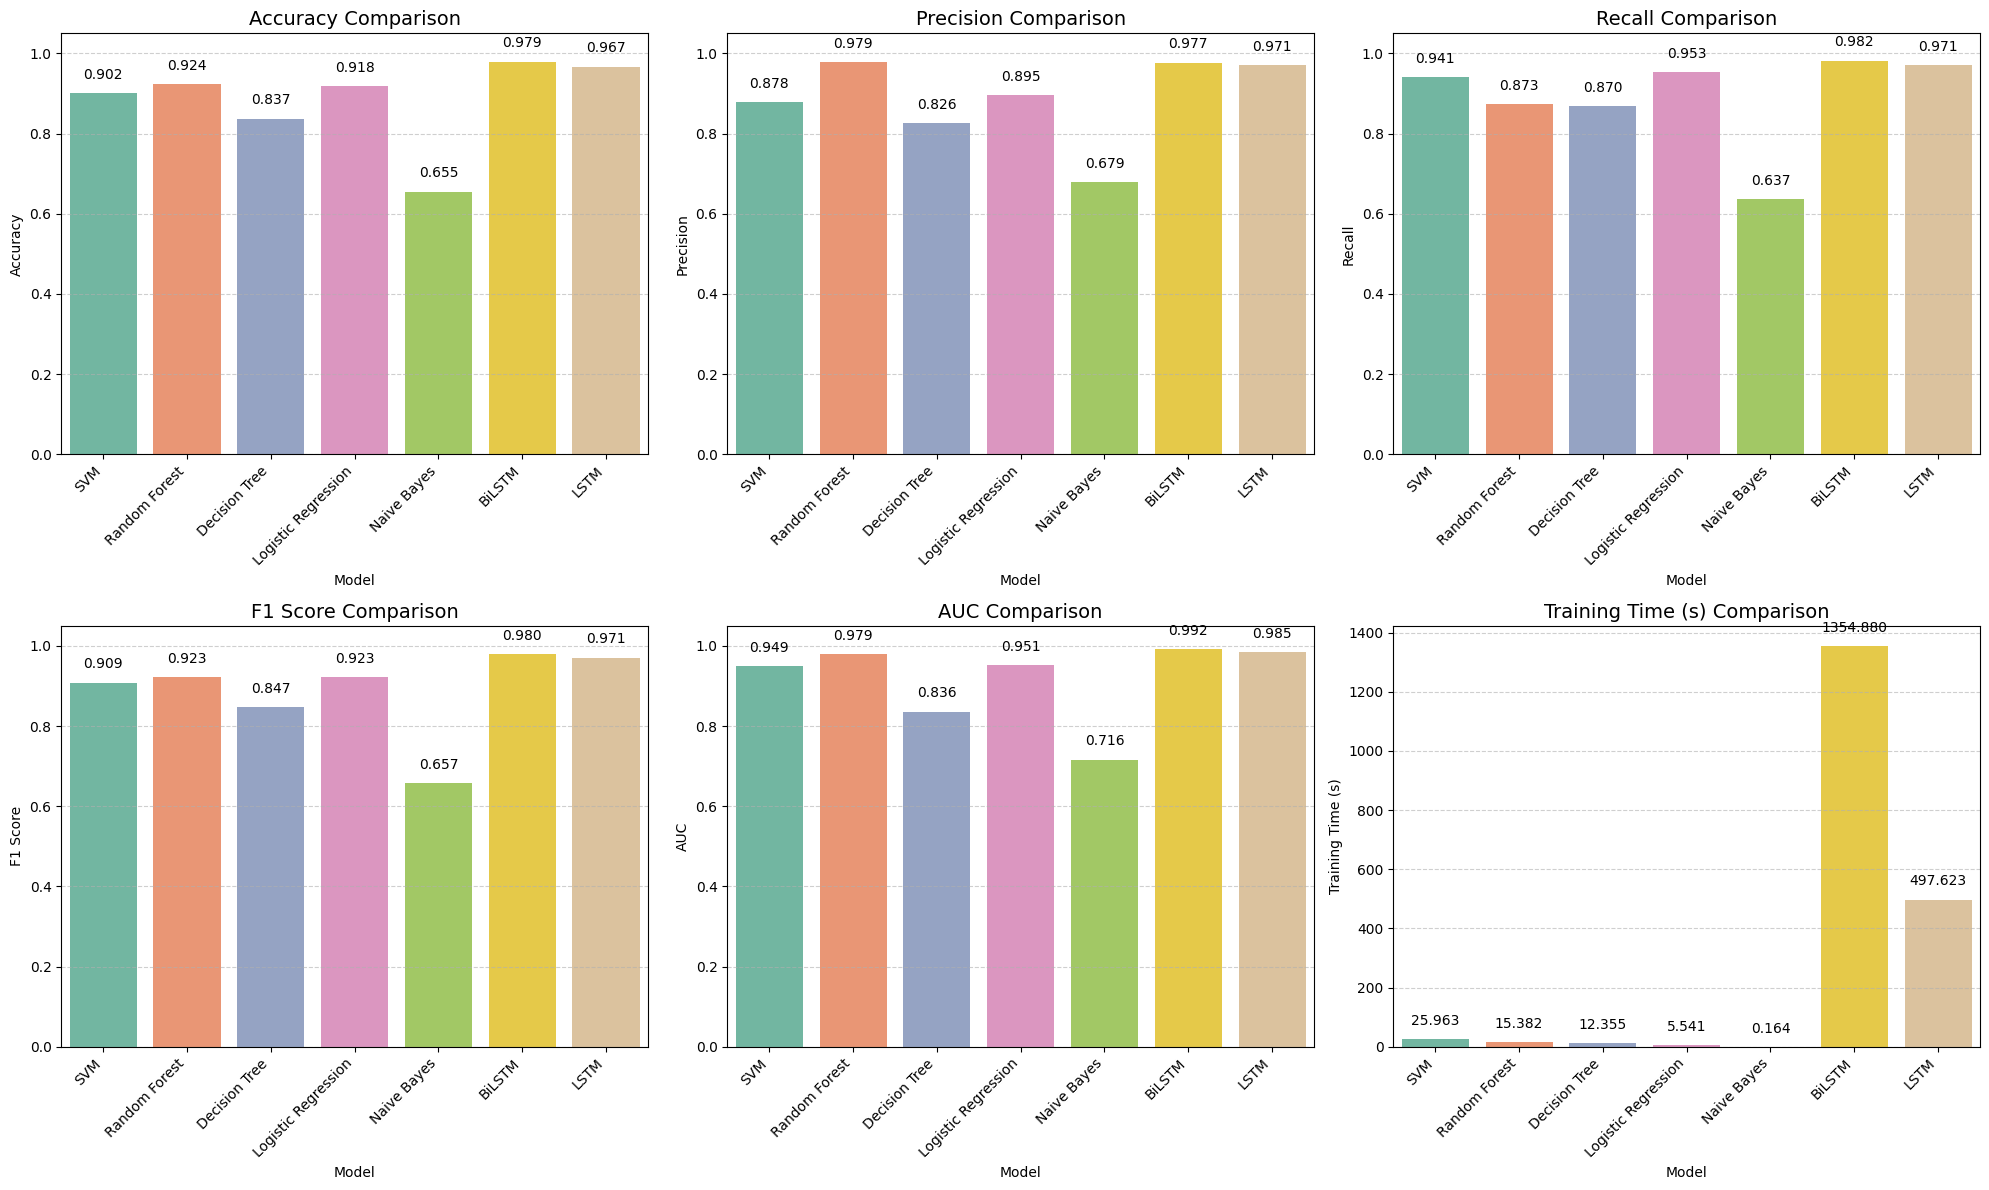

In [32]:
# Update LSTM accuracy
model_metrics[6]['Accuracy'] = 0.967000

# Now proceed with the plotting as before
results_df = pd.DataFrame(model_metrics)
colors = sns.color_palette("Set2", len(results_df['Model'].unique()))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Training Time (s)']

plt.figure(figsize=(20, 12))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    ax = sns.barplot(
        x='Model', 
        y=metric, 
        hue='Model', 
        data=results_df, 
        palette=colors,
        legend=False
    )
    plt.title(f'{metric} Comparison', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.3f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', xytext=(0, 8),
                    textcoords='offset points', fontsize=10)
    
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    if metric != 'Training Time (s)':
        plt.ylim(0, 1.05)

plt.tight_layout()
plt.savefig('final_model_comparison_with_updated_lstm.png')
plt.show()


In [33]:
print(model_metrics)

[{'Model': 'SVM', 'Accuracy': 0.9017713365539453, 'Precision': 0.8782608695652174, 'Recall': 0.9409937888198758, 'F1 Score': 0.9085457271364318, 'AUC': 0.9486175450258626, 'Training Time (s)': 25.96262216567993}, {'Model': 'Random Forest', 'Accuracy': 0.9243156199677939, 'Precision': 0.9790940766550522, 'Recall': 0.8726708074534162, 'F1 Score': 0.922824302134647, 'AUC': 0.9793774278651406, 'Training Time (s)': 15.381934642791748}, {'Model': 'Decision Tree', 'Accuracy': 0.8373590982286635, 'Precision': 0.8259587020648967, 'Recall': 0.8695652173913043, 'F1 Score': 0.8472012102874432, 'AUC': 0.8361204013377926, 'Training Time (s)': 12.355224132537842}, {'Model': 'Logistic Regression', 'Accuracy': 0.9178743961352657, 'Precision': 0.8950437317784257, 'Recall': 0.953416149068323, 'F1 Score': 0.9233082706766917, 'AUC': 0.9510791665801118, 'Training Time (s)': 5.541395902633667}, {'Model': 'Naive Bayes', 'Accuracy': 0.6553945249597424, 'Precision': 0.6788079470198676, 'Recall': 0.6366459627329

In [34]:
df = pd.DataFrame(model_metrics)
print(results_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1 Score      AUC  Training Time (s)
                SVM  0.901771   0.878261 0.940994  0.908546 0.948618          25.962622
      Random Forest  0.924316   0.979094 0.872671  0.922824 0.979377          15.381935
      Decision Tree  0.837359   0.825959 0.869565  0.847201 0.836120          12.355224
Logistic Regression  0.917874   0.895044 0.953416  0.923308 0.951079           5.541396
        Naive Bayes  0.655395   0.678808 0.636646  0.657051 0.716457           0.163599
             BiLSTM  0.979475   0.977126 0.982170  0.979613 0.992159        1354.880000
               LSTM  0.967000   0.970921 0.970800  0.970859 0.984550         497.622994


In [35]:
results_df.to_csv('model_results.csv', index=False)